## 모델 불러오기

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from dmba import classificationSummary

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pylab as plt
import numpy as np 
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from sklearn.ensemble  import VotingClassifier
from sklearn.metrics import accuracy_score

In [2]:
train_data = pd.read_csv('train_merge_data.csv')
test_data = pd.read_csv('test_merge_data.csv')

C:\Users\jsy39\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# 1. city, state 제거

train_data.drop(columns = ['city','state'], inplace = True)
test_data.drop(columns = ['city', 'state'], inplace = True)

In [4]:
# 2. description 정보 빼내기

train_data.loc[train_data['description'].str.contains('Terremoto', na=False),'description'] = 'Earthquake'
train_data.loc[train_data['description'].str.contains('futbol', na=False), 'description'] = 'Football'
# test_data에는 해당정보 없음. 

train_descriptions = pd.get_dummies(train_data['description'])[['Earthquake', 'Cyber Monday','Football', 'Black Friday', 'Dia de la Madre']]
train_data = train_data.merge(train_descriptions, how = 'left', left_index = True, right_index = True)
test_data['Earthquake'] = 0
test_data['Cyber Monday'] = 0
test_data['Football'] = 0
test_data['Black Friday'] = 0
test_data['Dia de la Madre'] = 0

print(train_data.shape)
print(test_data.shape)

(3054348, 27)
(28512, 26)


In [5]:
# type_x

train_data.type_x.unique()

train_data[train_data.type_x == 'Event']['description'].unique()
train_data[train_data.type_x == 'Bridge']['description'].unique()
train_data[train_data.type_x == 'Holiday']['description'].unique()
train_data[train_data.type_x == 'Additional']['description'].unique()
train_data[train_data.type_x == 'Transfer']['description'].unique()
train_data[train_data.type_x == 'Work Day']['description'].unique()

array(['Recupero puente Navidad', 'Recupero puente primer dia del ano',
       'Recupero Puente Navidad', 'Recupero Puente Primer dia del ano',
       'Recupero Puente Dia de Difuntos'], dtype=object)

In [6]:
# 4. holiday 변수 생성(휴일)

# National인 holiday 정보만 남긴다.
mask = (train_data.locale != 'National')
train_data.type_x[mask] = 'Empty'
train_data.locale[mask] = 'Empty'
train_data.locale_name[mask] = 'Empty'
train_data.transferred[mask] = 'Empty'

mask = (test_data.locale != 'National')
test_data.type_x[mask] = 'Empty'
test_data.locale[mask] = 'Empty'
test_data.locale_name[mask] = 'Empty'
test_data.transferred[mask] = 'Empty'

# 다른날로 대체된 날을 Empty로 변경
mask = (train_data.transferred == 'True')
train_data.type_x[mask] = 'Empty'
train_data.locale[mask] = 'Empty'
train_data.locale_name[mask] = 'Empty'
train_data.transferred[mask] = 'Empty'

mask = (test_data.transferred == 'True')
test_data.type_x[mask] = 'Empty'
test_data.locale[mask] = 'Empty'
test_data.locale_name[mask] = 'Empty'
test_data.transferred[mask] = 'Empty'

<ipython-input-6-5c0446a6d7b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.type_x[mask] = 'Empty'
<ipython-input-6-5c0446a6d7b2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.locale[mask] = 'Empty'
<ipython-input-6-5c0446a6d7b2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.locale_name[mask] = 'Empty'
<ipython-input-6-5c0446a6d7b2>:8: SettingWithCopyWarning: 
A value is trying to be set on a 

In [7]:
# 쉬는 날: holiday, additional, bridge
mask = ((train_data.type_x == 'Holiday') | (train_data.type_x == 'Additional') | (train_data.type_x == 'Bridge'))

# 주말이거나 holiday인 날을 no_work_day로 지정
train_data['no_work_day'] = train_data['Weekend'] | mask

# 테스트 데이터는 위의 정보가 없기 때문에 그냥 Weekend를 no_work_day로 변경
test_data['no_work_day'] = test_data['Weekend']

In [8]:
final_train_data = train_data.drop(columns = ['Unnamed: 0','id','type_x', 'locale', 'locale_name', 'transferred','Weekend','description'])
final_test_data = test_data.drop(columns = ['Unnamed: 0', 'id','type_x', 'locale', 'locale_name', 'transferred', 'description'])

In [9]:
final_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 20 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   store_nbr        int64  
 2   family           object 
 3   sales            float64
 4   onpromotion      int64  
 5   dcoilwtico       float64
 6   transactions     float64
 7   type_y           object 
 8   cluster          int64  
 9   Year             int64  
 10  Month            int64  
 11  Weekday          int64  
 12  trend            int64  
 13  NewYearsDay      bool   
 14  Earthquake       uint8  
 15  Cyber Monday     uint8  
 16  Football         uint8  
 17  Black Friday     uint8  
 18  Dia de la Madre  uint8  
 19  no_work_day      bool   
dtypes: bool(2), float64(3), int64(7), object(3), uint8(5)
memory usage: 323.3+ MB


In [10]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             28512 non-null  object 
 1   store_nbr        28512 non-null  int64  
 2   family           28512 non-null  object 
 3   onpromotion      28512 non-null  int64  
 4   dcoilwtico       28512 non-null  float64
 5   transactions     28512 non-null  float64
 6   type_y           28512 non-null  object 
 7   cluster          28512 non-null  int64  
 8   Year             28512 non-null  int64  
 9   Month            28512 non-null  int64  
 10  Weekend          28512 non-null  int64  
 11  Weekday          28512 non-null  int64  
 12  trend            28512 non-null  int64  
 13  NewYearsDay      28512 non-null  bool   
 14  Earthquake       28512 non-null  int64  
 15  Cyber Monday     28512 non-null  int64  
 16  Football         28512 non-null  int64  
 17  Black Friday

## modeling

In [11]:
sub_train_data = final_train_data[train_data.date <= '2016-07-31']
valid_data = final_train_data[train_data.date >= '2016-08-01']

In [12]:
print(final_train_data.shape)
print(sub_train_data.shape)
print(valid_data.shape)
print(final_test_data.shape)

(3054348, 20)
(2368278, 20)
(686070, 20)
(28512, 20)


In [13]:
# 검증 과정에서 사용할 데이터
sub_train_data.drop(columns = ['date'], inplace = True)
valid_data.drop(columns = ['date'], inplace = True)

# 최종 모델 훈련에서 사용할 데이터
final_train_data.drop(columns = ['date'], inplace = True)
final_test_data.drop(columns = ['date'], inplace = True)

C:\Users\jsy39\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


sub_train, valid

In [14]:
X_sub_train_data = sub_train_data.drop(columns = ['sales'])
y_sub_train_data = sub_train_data['sales']

X_valid_data = valid_data.drop(columns = ['sales'])
y_valid_data = valid_data['sales']

In [15]:
# 전처리

In [16]:
# store_nbr

X_sub_train_data = pd.get_dummies(X_sub_train_data,columns=['store_nbr']) 
X_valid_data = pd.get_dummies(X_valid_data,columns=['store_nbr'])
X_valid_data

,family,onpromotion,dcoilwtico,transactions,type_y,cluster,Year,Month,Weekday,trend,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
2368278,AUTOMOTIVE,0,40.05,1750.0,D,13,2016,8,0,1308,...,0,0,0,0,0,0,0,0,0,0
2368279,BABY CARE,0,40.05,1750.0,D,13,2016,8,0,1308,...,0,0,0,0,0,0,0,0,0,0
2368280,BEAUTY,0,40.05,1750.0,D,13,2016,8,0,1308,...,0,0,0,0,0,0,0,0,0,0
2368281,BEVERAGES,10,40.05,1750.0,D,13,2016,8,0,1308,...,0,0,0,0,0,0,0,0,0,0
2368282,BOOKS,0,40.05,1750.0,D,13,2016,8,0,1308,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,POULTRY,0,47.57,2155.0,B,6,2017,8,1,1687,...,0,0,0,0,0,0,0,0,0,0
3054344,PREPARED FOODS,1,47.57,2155.0,B,6,2017,8,1,1687,...,0,0,0,0,0,0,0,0,0,0
3054345,PRODUCE,148,47.57,2155.0,B,6,2017,8,1,1687,...,0,0,0,0,0,0,0,0,0,0
3054346,SCHOOL AND OFFICE SUPPLIES,8,47.57,2155.0,B,6,2017,8,1,1687,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# type_y

X_sub_train_data = pd.get_dummies(X_sub_train_data,columns=['type_y']) 
X_valid_data = pd.get_dummies(X_valid_data,columns=['type_y'])
X_valid_data

,family,onpromotion,dcoilwtico,transactions,cluster,Year,Month,Weekday,trend,NewYearsDay,...,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,type_y_A,type_y_B,type_y_C,type_y_D,type_y_E
2368278,AUTOMOTIVE,0,40.05,1750.0,13,2016,8,0,1308,False,...,0,0,0,0,0,0,0,0,1,0
2368279,BABY CARE,0,40.05,1750.0,13,2016,8,0,1308,False,...,0,0,0,0,0,0,0,0,1,0
2368280,BEAUTY,0,40.05,1750.0,13,2016,8,0,1308,False,...,0,0,0,0,0,0,0,0,1,0
2368281,BEVERAGES,10,40.05,1750.0,13,2016,8,0,1308,False,...,0,0,0,0,0,0,0,0,1,0
2368282,BOOKS,0,40.05,1750.0,13,2016,8,0,1308,False,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,POULTRY,0,47.57,2155.0,6,2017,8,1,1687,False,...,0,0,0,0,0,0,1,0,0,0
3054344,PREPARED FOODS,1,47.57,2155.0,6,2017,8,1,1687,False,...,0,0,0,0,0,0,1,0,0,0
3054345,PRODUCE,148,47.57,2155.0,6,2017,8,1,1687,False,...,0,0,0,0,0,0,1,0,0,0
3054346,SCHOOL AND OFFICE SUPPLIES,8,47.57,2155.0,6,2017,8,1,1687,False,...,0,0,0,0,0,0,1,0,0,0


In [18]:
# cluster

X_sub_train_data = pd.get_dummies(X_sub_train_data,columns=['cluster']) 
X_valid_data = pd.get_dummies(X_valid_data,columns=['cluster'])
X_valid_data

,family,onpromotion,dcoilwtico,transactions,Year,Month,Weekday,trend,NewYearsDay,Earthquake,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
2368278,AUTOMOTIVE,0,40.05,1750.0,2016,8,0,1308,False,0,...,0,0,0,0,0,1,0,0,0,0
2368279,BABY CARE,0,40.05,1750.0,2016,8,0,1308,False,0,...,0,0,0,0,0,1,0,0,0,0
2368280,BEAUTY,0,40.05,1750.0,2016,8,0,1308,False,0,...,0,0,0,0,0,1,0,0,0,0
2368281,BEVERAGES,10,40.05,1750.0,2016,8,0,1308,False,0,...,0,0,0,0,0,1,0,0,0,0
2368282,BOOKS,0,40.05,1750.0,2016,8,0,1308,False,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,POULTRY,0,47.57,2155.0,2017,8,1,1687,False,0,...,0,0,0,0,0,0,0,0,0,0
3054344,PREPARED FOODS,1,47.57,2155.0,2017,8,1,1687,False,0,...,0,0,0,0,0,0,0,0,0,0
3054345,PRODUCE,148,47.57,2155.0,2017,8,1,1687,False,0,...,0,0,0,0,0,0,0,0,0,0
3054346,SCHOOL AND OFFICE SUPPLIES,8,47.57,2155.0,2017,8,1,1687,False,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# family

X_sub_train_data = pd.get_dummies(X_sub_train_data,columns=['family']) 
X_valid_data = pd.get_dummies(X_valid_data,columns=['family'])
X_valid_data

,onpromotion,dcoilwtico,transactions,Year,Month,Weekday,trend,NewYearsDay,Earthquake,Cyber Monday,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
2368278,0,40.05,1750.0,2016,8,0,1308,False,0,0,...,0,0,0,0,0,0,0,0,0,0
2368279,0,40.05,1750.0,2016,8,0,1308,False,0,0,...,0,0,0,0,0,0,0,0,0,0
2368280,0,40.05,1750.0,2016,8,0,1308,False,0,0,...,0,0,0,0,0,0,0,0,0,0
2368281,10,40.05,1750.0,2016,8,0,1308,False,0,0,...,0,0,0,0,0,0,0,0,0,0
2368282,0,40.05,1750.0,2016,8,0,1308,False,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,0,47.57,2155.0,2017,8,1,1687,False,0,0,...,0,0,0,0,0,1,0,0,0,0
3054344,1,47.57,2155.0,2017,8,1,1687,False,0,0,...,0,0,0,0,0,0,1,0,0,0
3054345,148,47.57,2155.0,2017,8,1,1687,False,0,0,...,0,0,0,0,0,0,0,1,0,0
3054346,8,47.57,2155.0,2017,8,1,1687,False,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
X_sub = X_sub_train_data[['onpromotion', 'dcoilwtico', 'transactions']]
X_valid = X_valid_data[['onpromotion', 'dcoilwtico', 'transactions']]

scaler = StandardScaler()
scaler.fit(X_sub)
label = ['onpromotionn','dcoilwticoo','transactionss']
X_sub_trans = pd.DataFrame(scaler.transform(X_sub),columns=label)
X_valid_trans = pd.DataFrame(scaler.transform(X_valid),columns=label)

X_sub_train_data_trans = pd.concat([X_sub_trans,X_sub_train_data],axis=1)
X_valid_data_trans = pd.concat([X_valid_trans,X_valid_data],axis=1)

In [27]:
X_sub_train_data_trans

,onpromotionn,dcoilwticoo,transactionss,onpromotion,dcoilwtico,transactions,Year,Month,Weekday,trend,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,-0.147314,0.741502,-0.269291,0,93.140000,1420.876311,2013,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.147314,0.741502,-0.269291,0,93.140000,1420.876311,2013,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.147314,0.741502,-0.269291,0,93.140000,1420.876311,2013,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.147314,0.741502,-0.269291,0,93.140000,1420.876311,2013,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.147314,0.741502,-0.269291,0,93.140000,1420.876311,2013,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368273,-0.040527,-1.233201,0.468437,1,40.546667,2115.000000,2016,7,6,1307,...,0,0,0,0,0,1,0,0,0,0
2368274,-0.040527,-1.233201,0.468437,1,40.546667,2115.000000,2016,7,6,1307,...,0,0,0,0,0,0,1,0,0,0
2368275,0.173047,-1.233201,0.468437,3,40.546667,2115.000000,2016,7,6,1307,...,0,0,0,0,0,0,0,1,0,0
2368276,-0.147314,-1.233201,0.468437,0,40.546667,2115.000000,2016,7,6,1307,...,0,0,0,0,0,0,0,0,1,0


In [28]:
X_sub_train_data_trans.drop(columns = ['onpromotion','dcoilwtico','transactions'],inplace=True)
X_valid_data_trans.drop(columns = ['onpromotion','dcoilwtico','transactions'],inplace=True)

In [29]:
X_sub_train_data_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368278 entries, 0 to 2368277
Columns: 123 entries, onpromotionn to family_SEAFOOD
dtypes: bool(2), float64(3), int64(4), uint8(114)
memory usage: 388.5 MB


In [ ]:
# 모델 적합

# LinearRegression

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

model = LinearRegression()
model.fit(X_sub_train_data_trans, y_sub_train_data)
train_pred = model.predict(X_sub_train_data_trans)
train_pred[train_pred < 0] = 0

print(mean_squared_log_error(y_sub_train_data, train_pred))

5.997166490185716


다중 선형 회귀 모델 - 과적합(overfitting)되는 경향

필요이상으로 자세하게 특징값과 라벨값의 관계를 분석

일반화 능력(범용능력)이 떨어져 새로운 데이터를 제대로 예측하지 못함 


-> LASSO와 Ridge는 선형 회귀의 단점을 보완해 범용성을 부여하기 위해 만들어진 도구들

- 일부분만 중요하다면 라쏘가, 특성의 중요도가 전체적으로 비슷하다면 릿지가 좀 더 괜찮은 모델

In [31]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Lasso

- MSE가 최소가 되게 하는 가중치와 편향을 찾으면서 동시에, 가중치들의 절댓값의 합이 최소가 되게 한다는 것
- 가중치의 모든 원소가 0이 되거나 0에 가깝게 되어야 함
- L1-norm(어떤 벡터 요소의 절대값의 합) 페널티를 가진 선형 회귀 방법

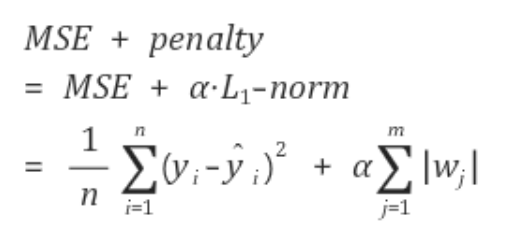

- m은 가중치의 갯수(혹은 특징의 갯수)
- α는 페널티의 효과를 조절해주는 하이퍼파라미터
- 알파가 커지면 페널티 항의 영향력이 커지고, 작아져서 거의 0이 되면 선형 회귀와 같아짐
- MSE와 penalty항의 합이 최소가 되게 하는 w와 b를 찾는 것이 바로 라쏘의 목적 

In [ ]:
# https://riverzayden.tistory.com/15

# 라쏘의 BEST 파라미터를 찾아주는 코드

lasso = Lasso()
alphas = np.logspace(0, 100)
parameters = {'alpha': alphas }
lasso_reg = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error',cv=5)
lasso_reg.fit(X_sub_train_data_trans, y_sub_train_data)  # X_train, y_train
print(lasso_reg.best_params_)
print(lasso_reg.best_score_)

In [32]:
# 파라미터

In [35]:
from sklearn.linear_model import Lasso

alpha = 2
lasso = Lasso(alpha=alpha)
lasso.fit(X_sub_train_data_trans, y_sub_train_data)  # X_train, y_train

MemoryError: Unable to allocate 2.17 GiB for an array with shape (123, 2368278) and data type object

In [ ]:
# predict
train_pred = lasso.predict(X_sub_train_data_trans)
valid_pred = lasso.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [ ]:
from sklearn.metrics import mean_squared_log_error

print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

# Ridge

- 패널티 항에 L1-norm 대신에 L2-norm 패널티
- 차이는 라쏘는 가중치들이 0이 되지만, 릿지의 가중치들은 0에 가까워질 뿐 0이 되지는 않음

In [ ]:
# 릿지의 BEST 파라미터를 찾아주는 코드

ridge = Ridge()
alphas = np.logspace(-4, 0, 200)
parameters = {'alpha': alphas }
ridge_reg = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=5)
ridge_reg.fit(X_sub_train_data_trans, y_sub_train_data)  # X_train, y_train
print(ridge_reg.best_params_)
print(ridge_reg.best_score_)

In [ ]:
# 파라미터

In [ ]:
from sklearn.linear_model import Ridge

alpha = 0.05
ridge = Ridge(alpha=alpha)
ridge.fit(X_sub_train_data_trans, y_sub_train_data)  # X_train, y_train

In [ ]:
# predict
train_pred = ridge.predict(X_sub_train_data_trans)
valid_pred = ridge.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [ ]:
from sklearn.metrics import mean_squared_log_error

print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

# Elastic Net

-  릿지회귀(Ridge Regression)과 라쏘회귀(Lasso Regression)을 절충한 모델
- 엘라스틱넷 회귀분석은 회귀계수들의 절대값의 합과 제곱합을 동시에 제약조건으로 가지는 방법으로 다음 식을 최소화시키는 회귀계수(β)을 찾는 것이 목적

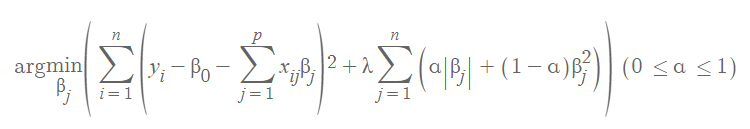

In [ ]:
# 엘라스틱넷의 BEST 파라미터를 찾아주는 코드

elasticnet = ElasticNet()
alphas = np.logspace(-4, 0, 200)
parameters = {'alpha': alphas }

elasticnet_reg = GridSearchCV(elasticnet, parameters, scoring='neg_mean_squared_error',cv=5)
elasticnet_reg.fit(X_sub_train_data_trans, y_sub_train_data)
print(elasticnet_reg.best_params_)
print(elasticnet_reg.best_score_)

In [ ]:
# 파라미터

In [ ]:
from sklearn.linear_model import ElasticNet

alpha = 0.05
elasticnet = ElasticNet(alpha=alpha)
elasticnet.fit(X_sub_train_data_trans, y_sub_train_data)  # X_train, y_train

In [ ]:
# predict
train_pred = elasticnet.predict(X_sub_train_data_trans)
valid_pred = elasticnet.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [ ]:
from sklearn.metrics import mean_squared_log_error

print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))